# 第 7 章实例：预测泰坦尼克号幸存者

In [1]:
import pandas as pd
import numpy as np

In [2]:
def read_data_set(fname):
    data = pd.read_csv(fname, index_col=0)
    # 丢弃没有用的数据
    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    # 处理性别数据
    data['Sex'] = (data['Sex'] == 'male').astype('int')
    labels = data['Embarked'].unique().tolist()
    
    data['Embarked'] = data['Embarked'].apply(lambda n: labels.index(n))
    data = data.fillna(0)
    return data

In [3]:
train = read_data_set('./datasets/titanic/train.csv')

In [4]:
y = train['Survived'].values
train.drop(['Survived'], axis=1, inplace=True)

X = train.values

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666)

In [6]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [7]:
score

0.7877094972067039

## 最佳超参数寻找

+ max_depth。

In [8]:
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (train_score, cv_score)

In [9]:
depths = range(2, 15)  # [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [10]:
list(depths)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [11]:
scores = [cv_score(d) for d in depths]
scores

[(0.7879213483146067, 0.7821229050279329),
 (0.8146067415730337, 0.7877094972067039),
 (0.8230337078651685, 0.7877094972067039),
 (0.8525280898876404, 0.7877094972067039),
 (0.8735955056179775, 0.7877094972067039),
 (0.8974719101123596, 0.8044692737430168),
 (0.9058988764044944, 0.8044692737430168),
 (0.9213483146067416, 0.776536312849162),
 (0.9410112359550562, 0.8044692737430168),
 (0.9578651685393258, 0.7988826815642458),
 (0.9620786516853933, 0.7932960893854749),
 (0.9705056179775281, 0.7821229050279329),
 (0.976123595505618, 0.7821229050279329)]

In [12]:
train_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

In [13]:
# 看验证集中分数最高的，关注泛化性能
best_score_index = np.argmax(cv_scores)
best_score_index

5

In [14]:
best_score = cv_scores[best_score_index]

In [15]:
best_score

0.8044692737430168

In [16]:
best_param = depths[best_score_index]

In [17]:
best_param

7

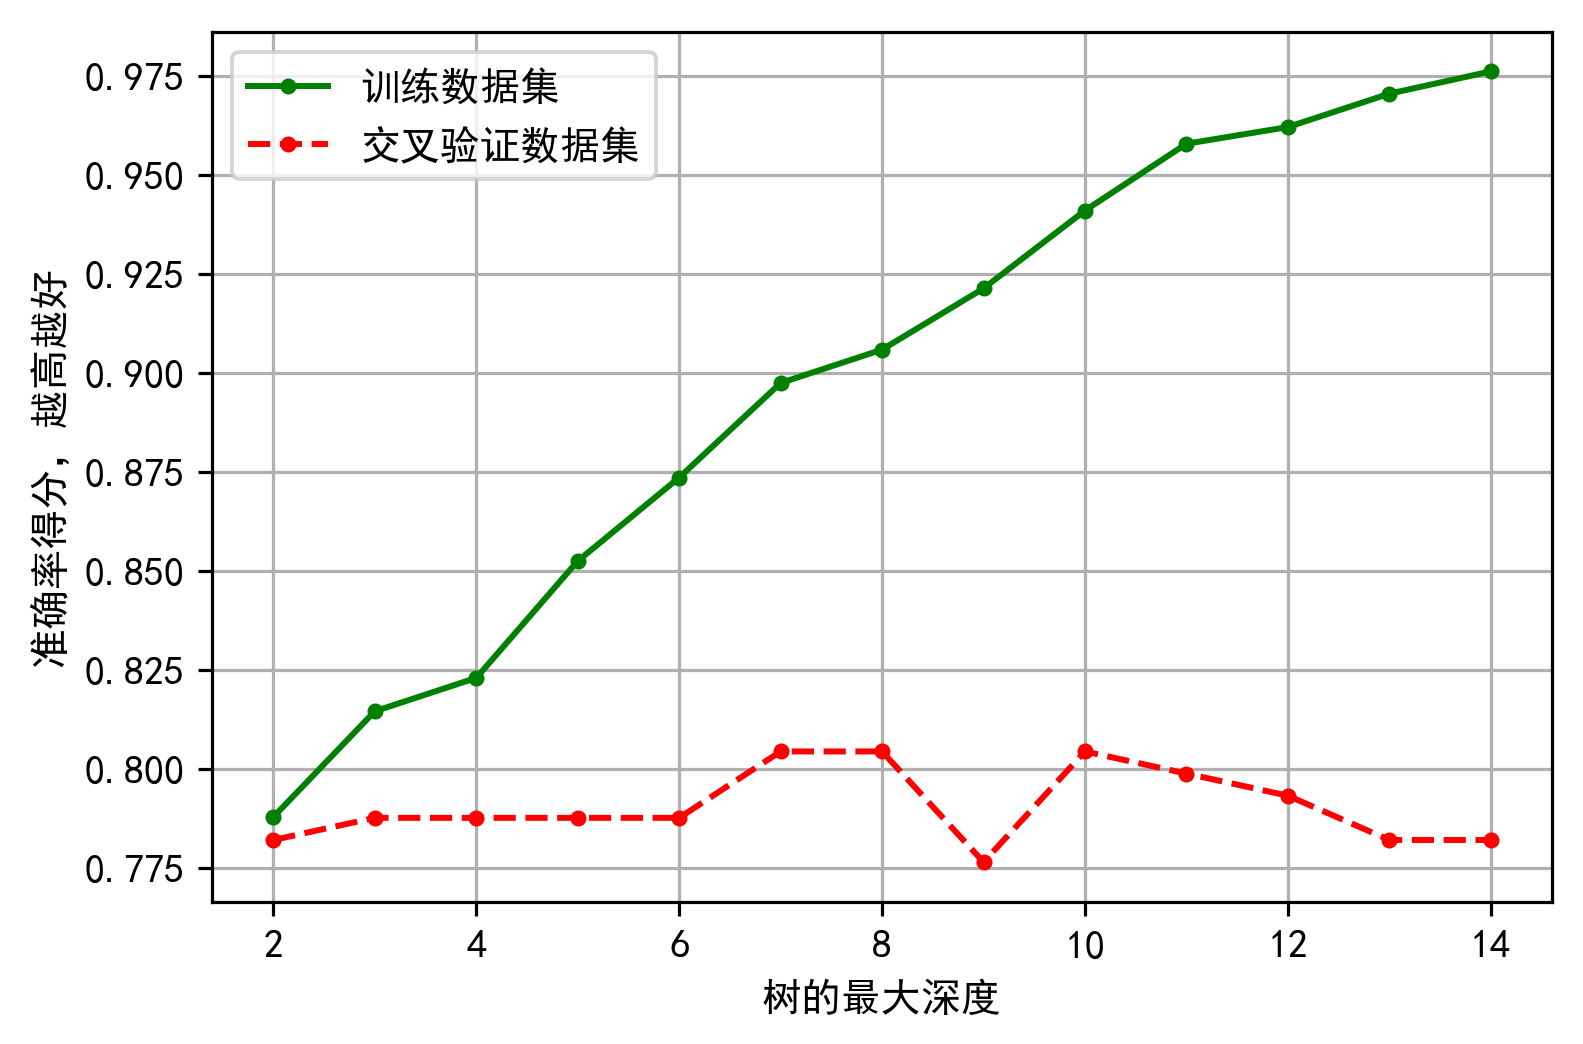

In [18]:
plt.figure(figsize=(6, 4), dpi=144)
plt.grid()
plt.xlabel('树的最大深度')
plt.ylabel('准确率得分，越高越好')
plt.plot(depths, train_scores, '.g-', label='训练数据集')
plt.plot(depths, cv_scores, '.r--', label='交叉验证数据集')
plt.legend()
plt.show()

+ min_impurity_decrease。

In [19]:
def cv_score_min_impurity_split(value):
    clf = DecisionTreeClassifier(criterion='gini', min_impurity_decrease=value)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_test, y_test)
    return (train_score, cv_score)

In [20]:
values = np.linspace(0, 0.5, 50)
scores = [cv_score_min_impurity_split(val) for val in values]

In [21]:
train_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

In [22]:
best_param_index = np.argmax(cv_scores)

In [23]:
values[best_param_index]

0.04081632653061224

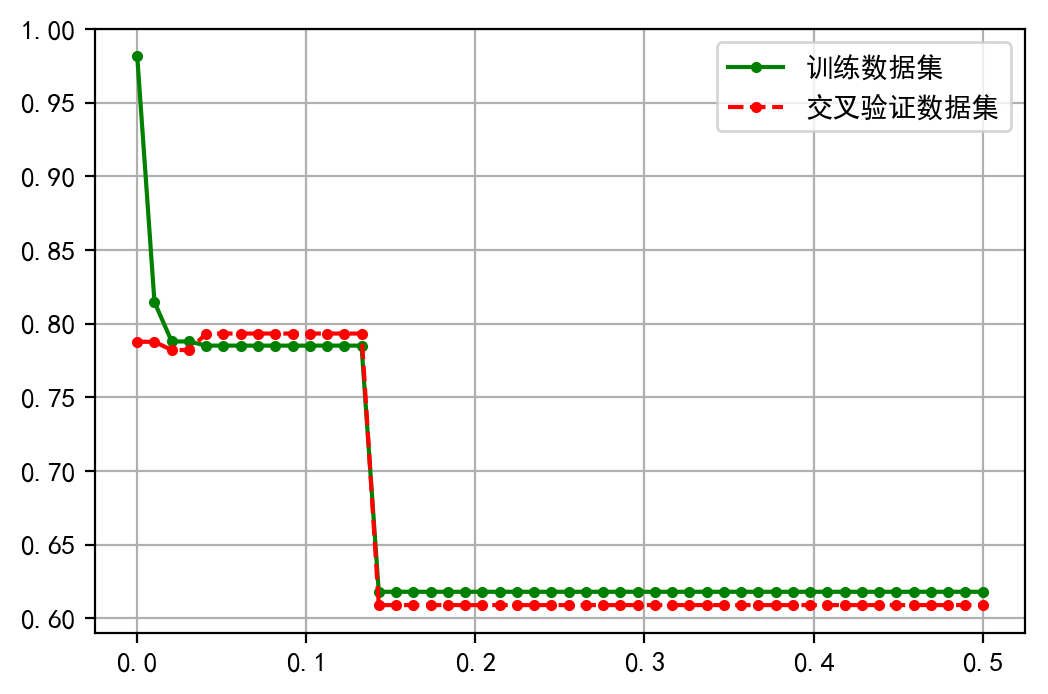

In [24]:
plt.figure(figsize=(6, 4), dpi=100)
plt.grid()
plt.plot(values, train_scores, '.g-', label='训练数据集')
plt.plot(values, cv_scores, '.r--', label='交叉验证数据集')
plt.legend()
plt.show()

In [25]:
from sklearn.model_selection import GridSearchCV

thresholds = np.linspace(0, 0.5, 50)

In [26]:
param_grid = {'min_impurity_decrease': thresholds}

In [27]:
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5)

In [28]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_impurity_decrease': array([0.     , 0.0102 , 0.02041, 0.03061, 0.04082, 0.05102, 0.06122,
       0.07143, 0.08163, 0.09184, 0.10204, 0.11224, 0.12245, 0.13265,
       0.14286, 0.15306, 0.16327, 0.17347, 0.18367, 0.19388, 0.20408,
       0.21429, 0.22449, 0.23469, 0.2449 , 0.2551 , 0...16, 0.41837,
       0.42857, 0.43878, 0.44898, 0.45918, 0.46939, 0.47959, 0.4898 ,
       0.5    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
clf.best_params_

{'min_impurity_decrease': 0.01020408163265306}

In [30]:
clf.best_score_

0.7865168539325843

## 网格搜索最佳超参数

In [31]:
entropy_thresholds = np.linspace(0, 1, 50)
gini_thresholds = np.linspace(0, 0.5, 50)

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'criterion': ['entropy'],
    'min_impurity_decrease': entropy_thresholds
}, {
    'criterion': ['gini'],
    'min_impurity_decrease': gini_thresholds
}, {
    'max_depth': range(2, 10)
}, {
    'min_impurity_decrease': range(2, 30, 2)
}]
clf = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 122 candidates, totalling 610 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 610 out of 610 | elapsed:    2.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'criterion': ['entropy'], 'min_impurity_decrease': array([0.     , 0.02041, 0.04082, 0.06122, 0.08163, 0.10204, 0.12245,
       0.14286, 0.16327, 0.18367, 0.20408, 0.22449, 0.2449 , 0.26531,
       0.28571, 0.30612, 0.32653, 0.34694, 0.36735, 0.38776, 0.40816,
       0.42857, 0.44898, 0...0.4898 ,
       0.5    ])}, {'max_depth': range(2, 10)}, {'min_impurity_decrease': range(2, 30, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [33]:
clf.best_params_

{'criterion': 'entropy', 'min_impurity_decrease': 0.02040816326530612}

In [34]:
clf.best_score_

0.797752808988764

In [35]:
best_estimator = clf.best_estimator_

In [36]:
best_estimator.score(X_test, y_test)

0.7877094972067039